# Общие подготовительные действия

Подключение необходимых библиотек.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder

sns.set_theme()

Создание объектов DataFrame из csv-файлов с данными.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holiday_events = pd.read_csv("holidays_events.csv")
transactions = pd.read_csv("transactions.csv")

# Первичный анализ данных

## Файл `train.csv`

Содержит записи о продажах товаров в определённых магазинах и в определённые даты.

Включает в себя следующие столбцы:
- `id` - уникальный идентификатор записи;
- `date` - дата, содержащая год, месяц и день;
- `store_nbr` - уникальный идентификатор магазина;
- `family` - категория продаваемых товаров;
- `sales` - количество проданных товаров (в граммах, литрах, штуках и пр. в зависимости от категории);
- `onpromotion` - количество рекламированных товаров конкретной категории.

In [338]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Посмотрим, есть ли пропуски в этой таблице.

In [339]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Рассмотрим распределение продаж по датам.

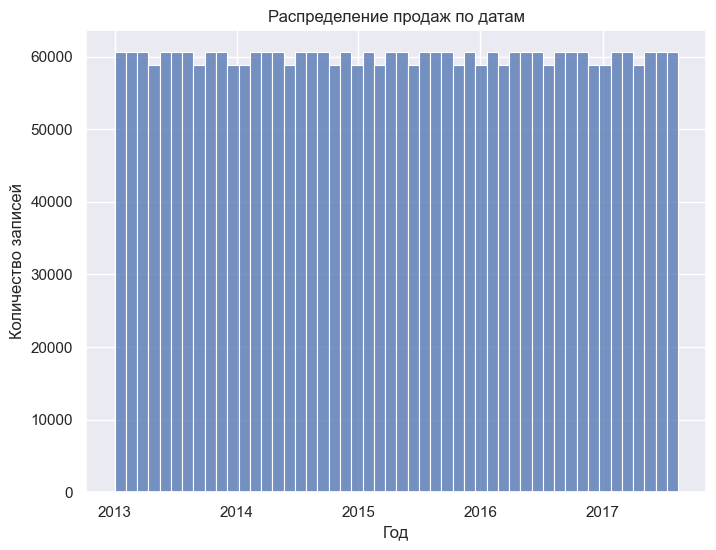

In [340]:
plt.figure(figsize=(8, 6))
sns.histplot(train.date.astype("datetime64[ns]"), bins=50).set(
    title="Распределение продаж по датам", xlabel="Год", ylabel="Количество записей"
);

Видно, что распределение продаж по датам равномерное и не содержит никаких явно заметных пропусков.

Рассмотрим распределение продаж по магазинам.

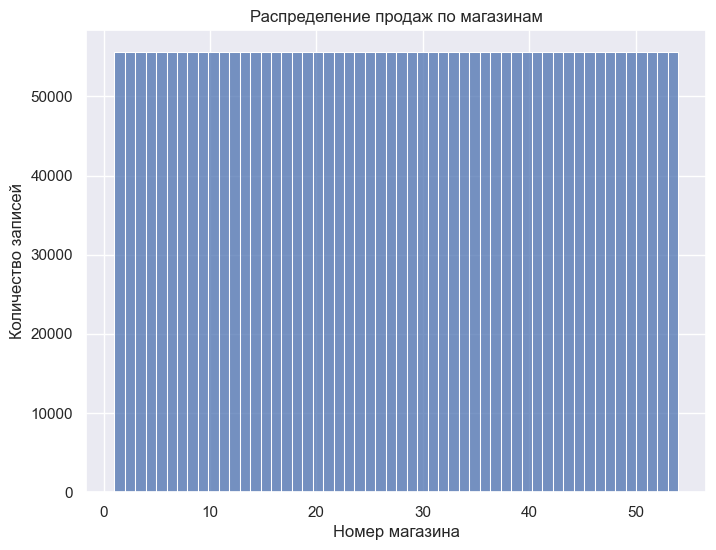

In [341]:
plt.figure(figsize=(8, 6))
sns.histplot(x=train.store_nbr, bins=54).set(
    title="Распределение продаж по магазинам",
    xlabel="Номер магазина", ylabel="Количество записей"
);

Видно, что распределение продаж по магазинам также равномерно и количество записей для каждого магазина одинаково.

Рассмотрим распределение продаж по категориям товаров.

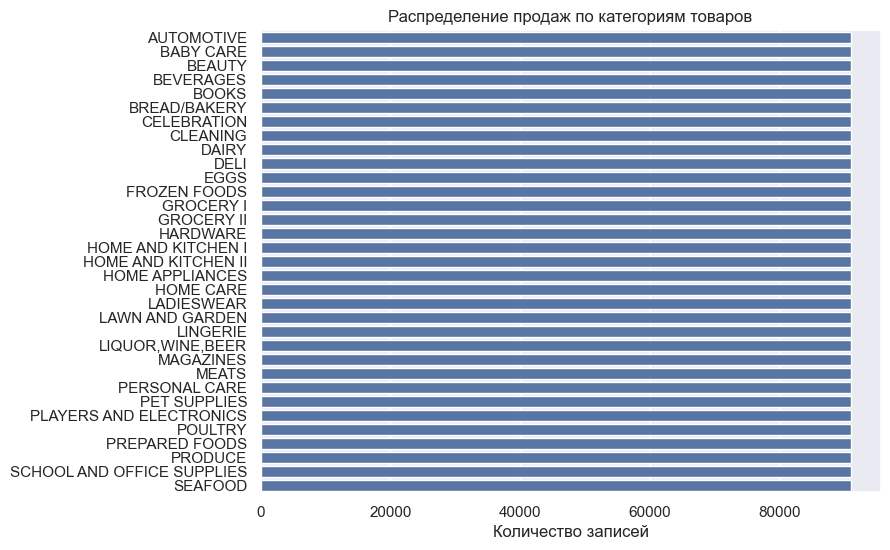

In [342]:
plt.figure(figsize=(8, 6))
sales_family_counts = train.family.value_counts()
sns.barplot(x=sales_family_counts.values, y=sales_family_counts.index).set(
    title="Распределение продаж по категориям товаров",
    xlabel="Количество записей", ylabel=""
);

Видно, что распределение продаж по категориям товаров также равномерно и количество записей для каждой категории одинаково.

Рассмотрим распределение количества проданных товаров в условных единицах (граммы, литры, штуки и пр. в зависимости от категории).

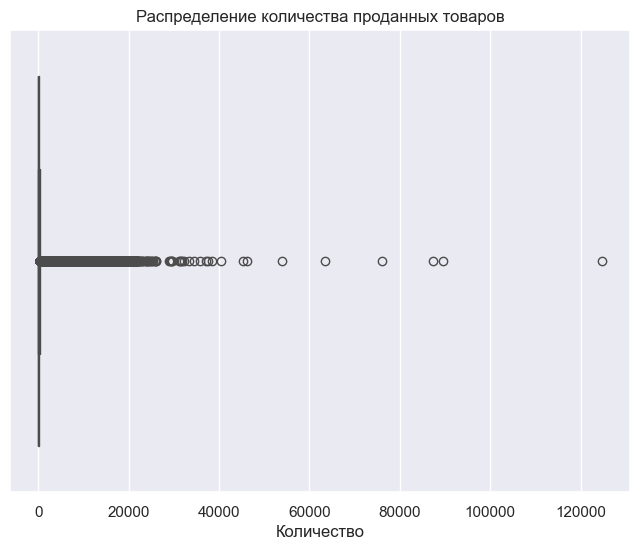

In [343]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train.sales).set(
    title="Распределение количества проданных товаров", xlabel="Количество"
);

Видно, что распределение очень сильно смещено влево. Это может быть обусловлено наличием таких категорий, товары которых приобретаются людьми сравнительно редко (например, бытовая техника, мебель, компьютерное оборудование и т. п.).

Также, посмотрим какую долю от всего набора данных составляют записи, где продажи отсуствуют, т. е. `sales = 0`.

In [344]:
print(f"{(train[train.sales == 0].sales.count() * 100 / len(train)):.1f}%")

31.3%


Рассмотрим распределение количества рекламированных товаров.

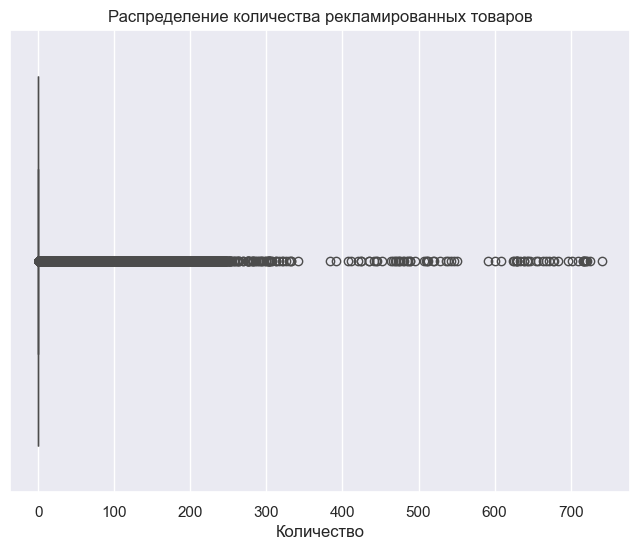

In [345]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train.onpromotion).set(
    title="Распределение количества рекламированных товаров", xlabel="Количество"
);

Видно, что распределение очень сильно смещено влево аналогично распределению количеству проданных товаров.

Также, посмотрим какую долю от всего набора данных составляют записи, где реклама отсуствует, т. е. `onpromotion = 0`.

In [346]:
print(f"{(train[train.onpromotion == 0].onpromotion.count() * 100 / len(train)):.1f}%")

79.6%


## Файл `test.csv`

Файл `test.csv` по структуре и содержанию аналогичен файлу `train.csv` и содержит все те же столбцы за исключением столбца `sales`.

In [347]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


Т. к. в этой таблице отсутствует целевой признак `sales`, то в данном задании не имеет смысла её использовать.

## Файл `sample_submission.csv`

Этот набор данных использовался для соревнования на kaggle.com, поэтому данный файл служит образцом для отправки своих ответов.

Включает в себя следующие столбцы:
- `id` - уникальный идентификатор записи;
- `sales` - предсказанное количество проданных товаров.

In [348]:
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


Эту таблицу также не имеет смысла использовать при выполнении данного задания.

## Файл `stores.csv`

Содержит основную информацию о магазинах.

Включает в себя следующие столбцы:
- `store_nbr` - уникальный идентификатор магазина;
- `city` - город, в котором расположен магазин;
- `state` - провинция, в которой расположен магазин;
- `type` - тип магазина;
- `cluster` - группа похожих магазинов.

In [349]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


Рассмотрим распределение магазинов по городам.

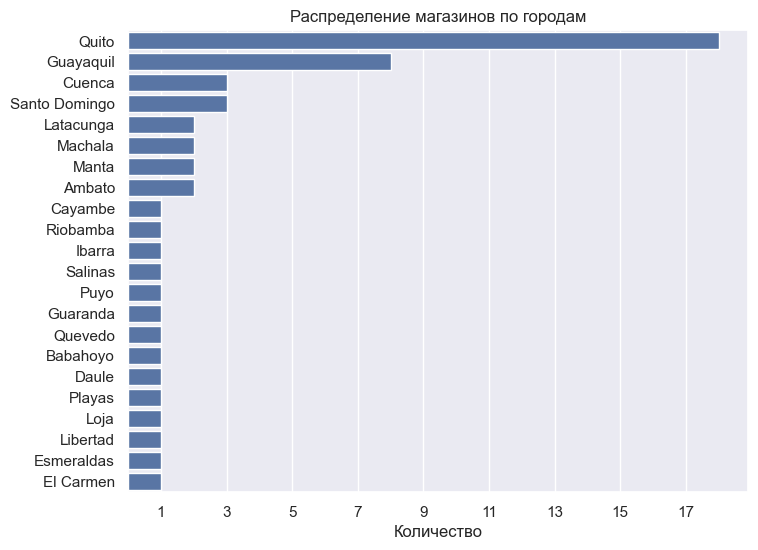

In [350]:
store_city_counts = stores.city.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=store_city_counts.values, y=store_city_counts.index).set(
    title="Распределение магазинов по городам",
    xlabel="Количество", ylabel="", xticks=range(1, 18, 2)
);

Видно, что половина магазинов расположена в городах Кито и Гуаякиль, являющихся самыми крупными в Эквадоре.

Рассмотрим распределение магазинов по провинциям.

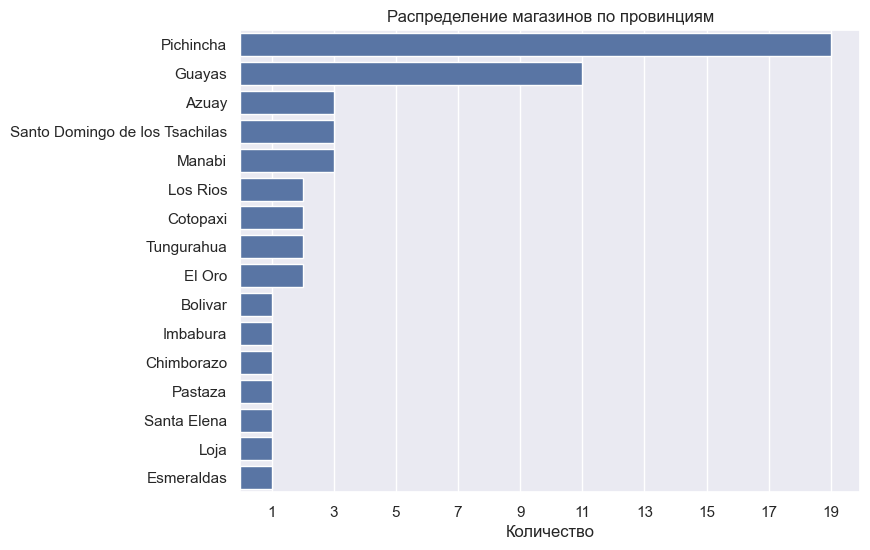

In [351]:
store_state_counts = stores.state.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=store_state_counts.values, y=store_state_counts.index).set(
    title="Распределение магазинов по провинциям",
    xlabel="Количество", ylabel="", xticks=range(1, 20, 2)
);

Видно, что половина магазинов расположена в провинциях Пичинча и Гуаяс, административными центрами которых являются города Кито и Гуякиль соответственно, т. е. данные провинции Эквадора являются наиболее густонаселёнными.

Рассмотрим распределение магазинов по типам.

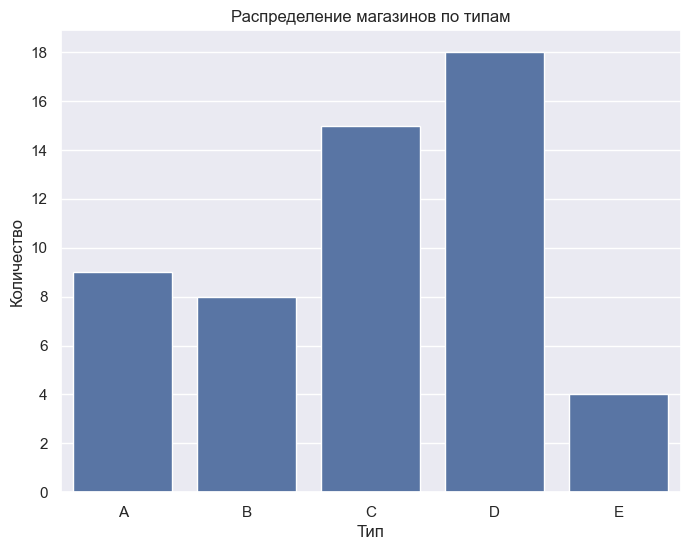

In [352]:
store_type_counts = stores.type.value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values).set(
    title="Распределение магазинов по типам",
    xlabel="Тип", ylabel="Количество", yticks=range(0, 19, 2)
);

Видно, что наиболее распространёнными являются магазины типов `C` и `D`, а меньше всего магазинов типа `E`. Можно предположить, что тип магазина зависит от его размеров (например, супермаркет, гипермаркет и т. д.) или от категорий товаров, продаваемых в нём (например, магазин бытовой техники, продуктовый магазин и т. д.).

Рассмотрим распределение магазинов по группам.

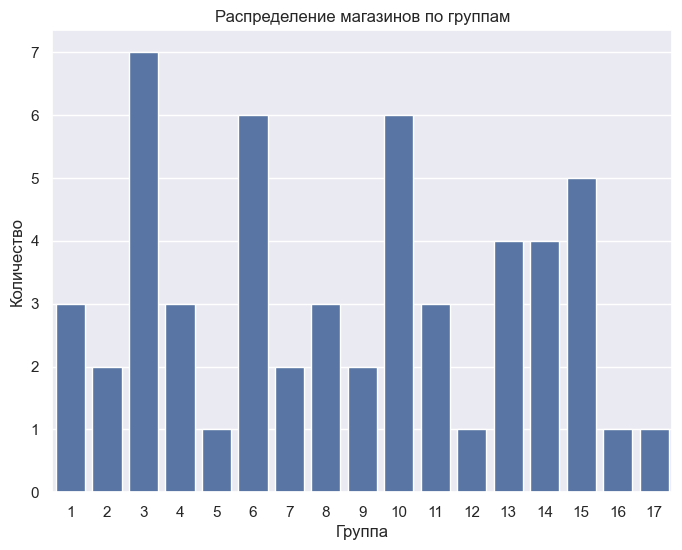

In [353]:
store_cluster_counts = stores.cluster.value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=store_cluster_counts.index, y=store_cluster_counts.values).set(
    title="Распределение магазинов по группам",
    xlabel="Группа", ylabel="Количество"
);

Видно, что есть как крупные группы с несколькими магазинами (4-7), так и малые группы (1-3). Можно предположить, что магазины сгруппированы по расположению или по популярности среди покупателей.

## Файл `oil.csv`

Содержит ежедневные цены на нефть.

Включает следующие столбцы:
- `date` - дата, содержащая год, месяц и день;
- `dcoilwtico` - вероятнее всего, расшифровывается как Daily Crude Oil West Texas Intermediate Closing Offer, т. е. данный столбец содержит ежедневную цену закрытия на один баррель нефти марки WTI в долларах.

In [354]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


Посмотрим, сколько в этой таблице пропусков.

In [355]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

В данной таблице присутствует небольшое количество пропусков в сравнении с количеством записей в ней. Но также можно заметить, что некоторые даты пропущены и соотвественно точная цена на нефть в эти дни неизвестна.

Посмотрим общее количество дат, для которых имеются записи в наборе данных.

In [356]:
(train_test_len := train.date.nunique() + test.date.nunique())

1700

И посмотрим на количество дат с указанной ценой на нефть.

In [357]:
(oil_len := int(len(oil) - oil.dcoilwtico.isnull().sum()))

1175

Теперь посмотрим какую долю от всего набора данных составляют даты, для которых цена на нефть не указана.

In [358]:
print(f"{((train_test_len - oil_len) * 100 / train_test_len):.1f}%")

30.9%


Позже эти пропуски будет необходимо заполнить, т. к. с высокой долей вероятности объёмы продаж сильно зависят от цены на нефть.

Рассмотрим имеющееся распределение цены на нефть по датам.

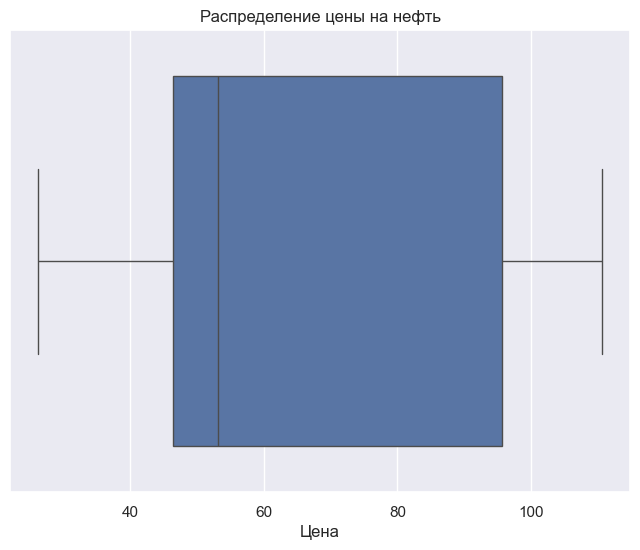

In [359]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=oil.dcoilwtico).set(
    title="Распределение цены на нефть", xlabel="Цена"
);

## Файл `holiday_events.csv`

Содержит основную информацию о всякого рода праздниках и событиях.

Включает следующие столбцы:
- `date` - дата, содержащая год, месяц и день;
- `type` - тип дня (праздник, дополнительный выходной или событие);
- `locale` - охват (местный, региональный, государственный);
- `locale_name` - название места, где отмечается праздник или происходит событие;
- `description` - описание праздника или события;
- `transferred` - совершался ли перенос праздника или события.

In [360]:
holiday_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Проверим, есть ли пропуски в этой таблице.

In [361]:
holiday_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Рассмотрим распределение праздников и событий по датам.

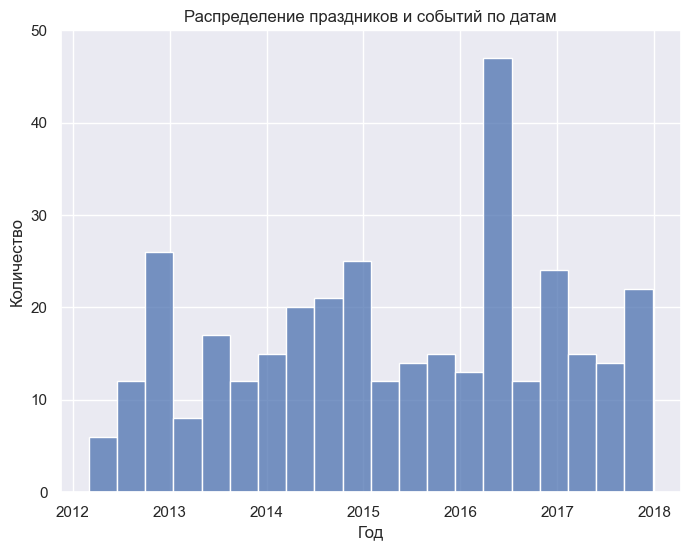

In [362]:
plt.figure(figsize=(8, 6))
sns.histplot(x=holiday_events.date.astype("datetime64[ns]"), bins=20).set(
    title="Распределение праздников и событий по датам",
    xlabel="Год", ylabel="Количество", yticks=range(0, 51, 10)
);

Видно, что по каким-то причинам на первую половину 2016 года приходится наибольшее количество событий. Это может быть связано с сильным землетрясением, потрясшим Эквадор 16 апреля 2016 года. Остальное распределение является достаточно равномерным.

Рассмотрим распределение праздников и событий по типам.

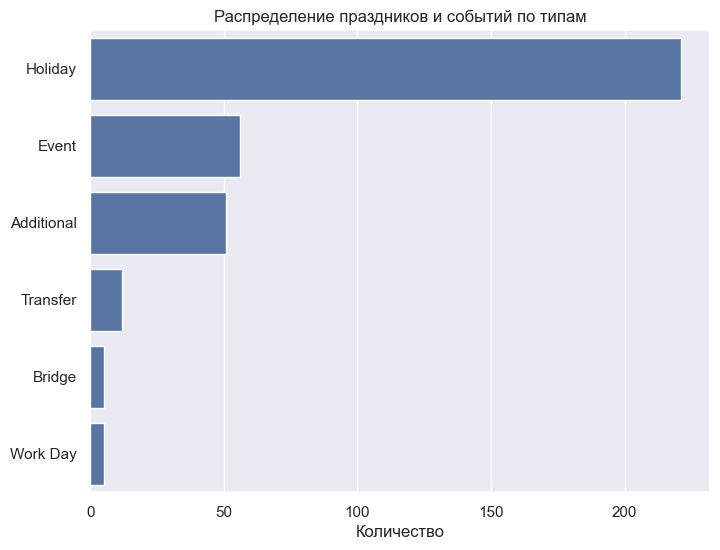

In [363]:
event_type_counts = holiday_events.type.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=event_type_counts.values, y=event_type_counts.index).set(
    title="Распределение праздников и событий по типам",
    xlabel="Количество", ylabel=""
);

Видно, что праздничных дней больше всего. Затем идут обозначения, которые следует рассмотреть подробнее, т. к. однозначно нельзя сказать, что имеется в виду.

Посмотрим на несколько примеров праздничных дней.

In [364]:
holiday_events[holiday_events.type == "Holiday"]

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
338,2017-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False


Здесь представлены такие праздники, как Рождество, Новый Год, дни города, дни независимости и т. п.

Посмотрим на дни типа `Event`.

In [365]:
holiday_events[holiday_events.type == "Event"]

,date,type,locale,locale_name,description,transferred
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
103,2014-05-11,Event,National,Ecuador,Dia de la Madre,False
106,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil,False
107,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False
108,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False
113,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False
114,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
115,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
116,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False
117,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final,False


Здесь представлены такие события, как Чемпионат мира по футболу, землетрясение амплитудой в 7.8 баллов и некоторые другие события.

Посмотрим на дни типа `Additional`.

In [366]:
holiday_events[holiday_events.type == "Additional"]

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


Здесь представлены предпраздничные дни, а также первые дни сразу после Рождества.

Посмотрим на дни типа `Transfer`.

In [367]:
holiday_events[holiday_events.type == "Transfer"]

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


Здесь представлены праздничные дни, по каким-либо причинам перенесённые на несколько дней.

А теперь посмотрим на праздники, для которых в столбце `transferred` указано, что они были перенесены.

In [368]:
holiday_events[holiday_events.transferred]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


Оказывается, что это те же самые праздники, но с указанием дат, в которые они должны были бы проводиться без переноса.

Посмотрим на дни типа `Bridge`.

In [369]:
holiday_events[holiday_events.type == "Bridge"]

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


Здесь представлены дополнительные праздничные дни, примыкающие к таким праздникам, как Рождество, Новый Год и День Мёртвых.

Посмотрим на дни типа `Word Day`.

In [370]:
holiday_events[holiday_events.type == "Work Day"]

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


Здесь представлены дополнительные рабочие дни, которые призваны возместить дополнительные праздничные дни типа `Bridge`.

Рассмотрим распределение праздников и событий по охвату.

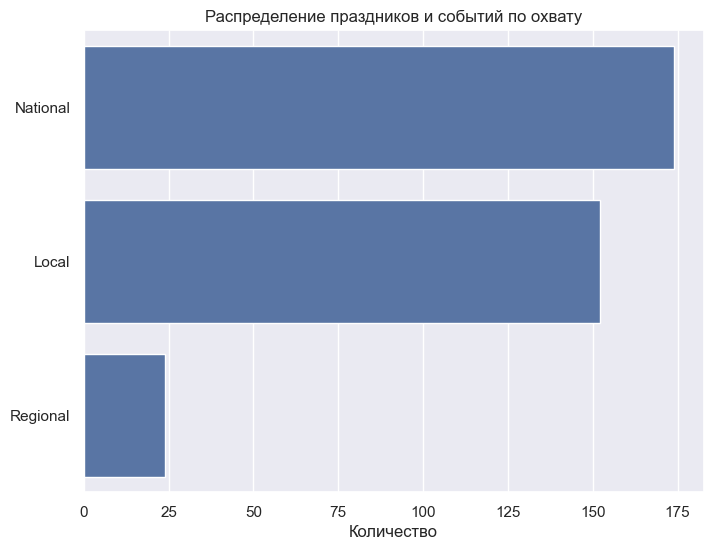

In [371]:
event_locale_counts = holiday_events.locale.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=event_locale_counts.values, y=event_locale_counts.index).set(
    title="Распределение праздников и событий по охвату",
    xlabel="Количество", ylabel=""
);

Видно, что региональных праздников и событий достаточно мало в сравнении с государственными и местными.

Рассмотрим распределение праздников и событий по местам.

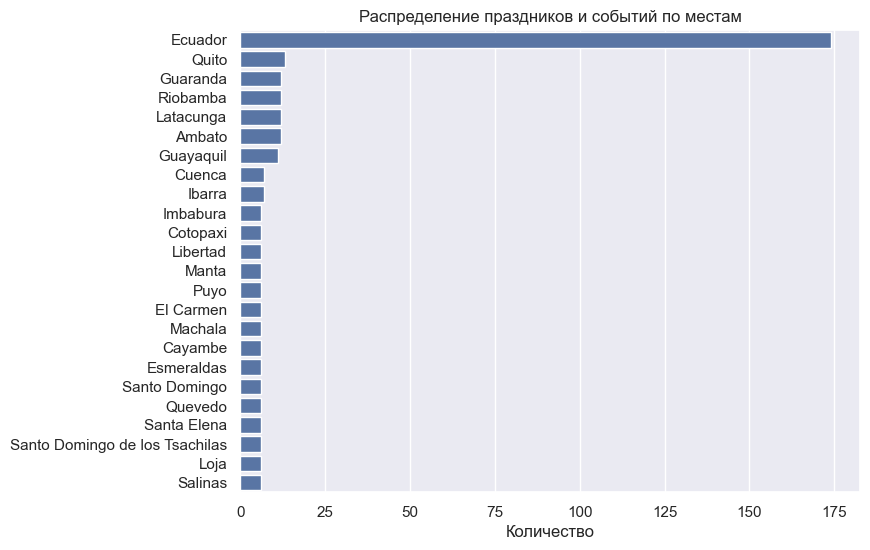

In [372]:
event_locale_name_counts = holiday_events.locale_name.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=event_locale_name_counts.values, y=event_locale_name_counts.index).set(
    title="Распределение праздников и событий по местам",
    xlabel="Количество", ylabel=""
);

Видно, что местные и региональные праздники и события достаточно равномерно распределены по местам, где они отмечаются и проводятся соответственно. Количество праздников и событий, отмечаемых и проводимых в Эквадоре, совпадает с количеством государственных особых дней, как и должно быть.

Посмотрим на количество перенесённых праздничных дней.

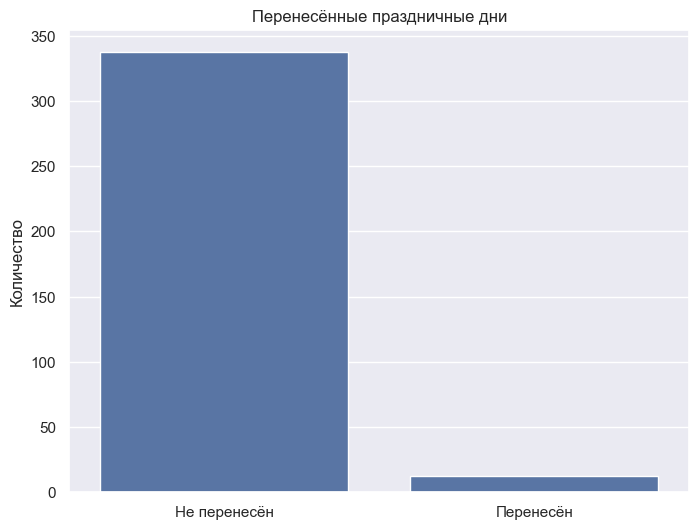

In [373]:
plt.figure(figsize=(8, 6))
sns.countplot(x=holiday_events.transferred).set(
    title="Перенесённые праздничные дни",
    xlabel="", ylabel="Количество",
    xticks=range(2), xticklabels=["Не перенесён", "Перенесён"]
);

Перенесённых праздничных дней совсем немного. Посмотрим на них подробнее.

In [374]:
holiday_events[holiday_events.transferred == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


## Файл `transactions.csv`

Содержит информацию об общем количестве транзакций в определённых магазинах в определённые даты.

Включает следующие столбцы:
- `date` - дата, содержащая год, месяц и день;
- `store_nbr` - уникальный идентификатор магазина;
- `transactions` - общее количество транзакций.

In [375]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


Предположим, что эта таблица содержит общее количество покупок, которые были совершены в конкретный день в конкретном магазине. Можно заметить, что, исходя из данной таблицы, 1 января 2013 года работал только один магазин из всей сети.

Проверим, так ли это, выбрав записи из набора данных за этот день с ненулевым объёмом продаж.

In [376]:
train[(train.date == "2013-01-01") & (train.sales != 0)]

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000000,0
564,564,2013-01-01,25,BEVERAGES,810.000000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589000,0
568,568,2013-01-01,25,CLEANING,186.000000,0
569,569,2013-01-01,25,DAIRY,143.000000,0
570,570,2013-01-01,25,DELI,71.090000,0
571,571,2013-01-01,25,EGGS,46.000000,0
572,572,2013-01-01,25,FROZEN FOODS,29.654999,0
573,573,2013-01-01,25,GROCERY I,700.000000,0
574,574,2013-01-01,25,GROCERY II,15.000000,0


И действительно, в этот день продажи имелись только у одного магазина, номер которого записан в таблице `transactions`.

Посмотрим, есть ли пропуски в этой таблице.

In [377]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

Рассмотрим распределение транзакций по датам.

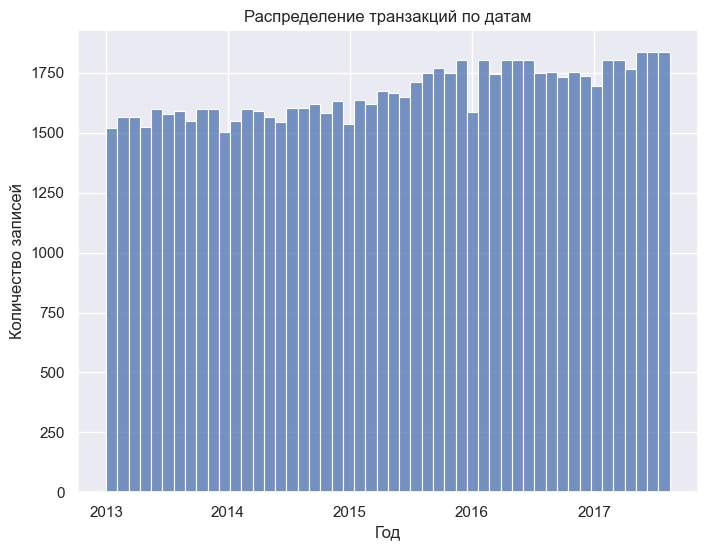

In [378]:
plt.figure(figsize=(8, 6))
sns.histplot(x=transactions.date.astype("datetime64[ns]"), bins=50).set(
    title="Распределение транзакций по датам",
    xlabel="Год", ylabel="Количество записей"
);

Видно, что в общем количество транзакций постепенно возрастает, поэтому можно предположить, что дела у этой сети магазинов постепенно улучшались в период с 2013 по 2017 год.

Рассмотрим распределение транзакций по магазинам.

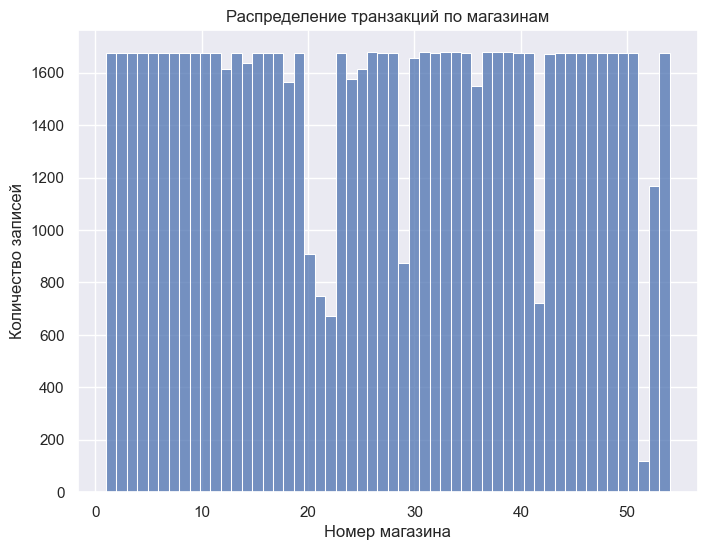

In [379]:
plt.figure(figsize=(8, 6))
sns.histplot(x=transactions.store_nbr, bins=54).set(
    title="Распределение транзакций по магазинам",
    xlabel="Номер магазина", ylabel="Количество записей"
);

Видно, что есть некоторое количество магазинов, которые не работали в какие-то дни, раз транзакций не производилось.

Рассмотрим распределение количества транзакций.

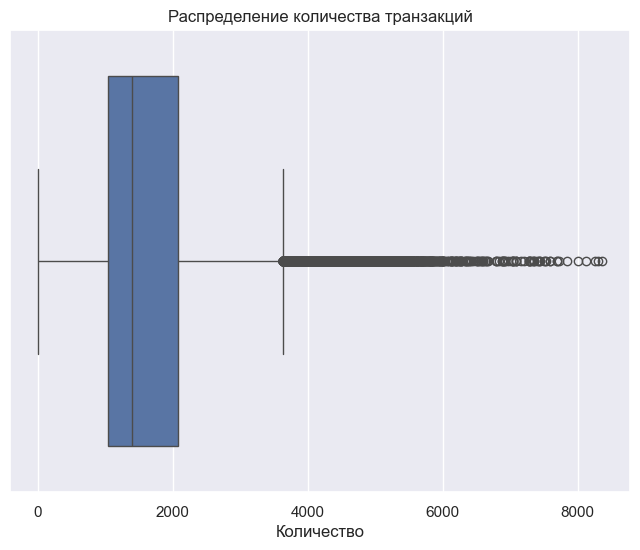

In [380]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=transactions.transactions).set(
    title="Распределение количества транзакций", xlabel="Количество"
);

Видно, что распределение нормально и смещено влево, а ярко выраженные аномалии отсутствуют.

# Создание единой таблицы с данными

Для начала скопируем таблицу `train`.

In [3]:
(sales := train.copy())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


Приведём столбец `date` к типу данных `datetime` и удалим столбец `id`, не имеющий пользы при решении данной задачи.

In [4]:
sales.date = sales.date.astype("datetime64[ns]")
(sales := sales.drop(columns=["id"]))

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


После удаления столбца с уникальными номерами записей проверим набор данных на наличие дупликатов.

In [5]:
sales[sales.duplicated()]

,date,store_nbr,family,sales,onpromotion


## Слияние с таблицей `transactions`

Ранее мы выяснили, что данная таблица содержит записи о количество совершённых транзакций для каждого магазина на каждую дату при условии, что в данном магазине в этот день были хоть какие-то продажи. Соответственно, для всех отсутствующих пар даты с номером магазина логично указать ноль, т. е. данный магазин в эту дату не работал или просто ничего не продал.

Таким образом, присоединим таблицу `transactions` по датам и номерам магазинов, заполнив отсутствующие значения нулями.

In [6]:
sales = pd.merge(
    sales,
    transactions.astype({"date": "datetime64[ns]"}),
    how="left",
    on=["date", "store_nbr"]
)
sales.transactions = sales.transactions.fillna(0).astype(int)
sales

,date,store_nbr,family,sales,onpromotion,transactions
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0
1,2013-01-01,1,BABY CARE,0.000,0,0
2,2013-01-01,1,BEAUTY,0.000,0,0
3,2013-01-01,1,BEVERAGES,0.000,0,0
4,2013-01-01,1,BOOKS,0.000,0,0
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155


## Слияние с таблицей `oil`

Создадим таблицу, где будут перечислены все даты с 1 января 2013 года по 31 августа 2017 года.

In [7]:
(oil_date_range := pd.DataFrame({
    "date": pd.date_range("2013-01-01", "2017-08-31", freq="D")
}))

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1699,2017-08-27
1700,2017-08-28
1701,2017-08-29
1702,2017-08-30


Присоединим созданную таблицу к таблице с ценами на нефть так, чтобы больше никакие даты не были пропущены.

In [8]:
(oil_new := pd.merge(
    oil.astype({"date": "datetime64[ns]"}),
    oil_date_range,
    how="right",
    on="date"
))

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
...,...,...
1699,2017-08-27,NaN
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


Теперь восстановим пропуски в этой таблице. Как было обнаружено ранее, они составляют около 30% от всех записей, что достаточно много.

Воспользуемся временной интерполяцией, т. к. она учитывает длину временных промежутков между имеющимися значениями.

In [9]:
(oil_new := oil_new.set_index("date").interpolate(method="time"))

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.140000
2013-01-03,92.970000
2013-01-04,93.120000
2013-01-05,93.146667
...,...
2017-08-27,46.816667
2017-08-28,46.400000
2017-08-29,46.460000


Заменим оставшийся пропуск ближайшим к нему значением, округлим цены, обратно сделаем дату отдельным столбцом и посмотрим на результат.

In [10]:
oil_new.at["2013-01-01", "dcoilwtico"] = oil_new.at["2013-01-02", "dcoilwtico"]
oil_new.dcoilwtico = oil_new.dcoilwtico.round(2)
(oil_new := oil_new.reset_index())

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.15
...,...,...
1699,2017-08-27,46.82
1700,2017-08-28,46.40
1701,2017-08-29,46.46
1702,2017-08-30,45.96


Присоединим изменённую таблицу `oil` с восстановленными ценами на нефть к таблице `sales` по датам `date`.

In [11]:
(sales := pd.merge(sales, oil_new, how="left", on="date"))

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14
4,2013-01-01,1,BOOKS,0.000,0,0,93.14
...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155,47.57


## Слияние с таблицей `stores`

Присоединим данную таблицу с информацией о магазинах по номерам магазинов `store_nbr`.

In [12]:
(sales := pd.merge(sales, stores, how="left", on="store_nbr"))

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000,0,0,93.14,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57,Quito,Pichincha,B,6
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57,Quito,Pichincha,B,6
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57,Quito,Pichincha,B,6
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155,47.57,Quito,Pichincha,B,6


## Слияние с таблицей `holiday_events`

Для начала выделим несколько дополнительных признаков из даты в основной таблице `sales`, а именно: год `year`, месяц `month`, день `day`, день недели `day_of_week`, является ли день выходным `is_calendar_weekend` и является ли день зарплатным `is_payday` (15 число и последний день каждого месяца).

In [13]:
sales["year"] = sales.date.dt.year
sales["month"] = sales.date.dt.month
sales["day"] = sales.date.dt.day
sales["day_of_week"] = sales.date.dt.day_of_week
sales["is_calendar_weekend"] = sales.day_of_week.isin([5, 6]).astype(int)
sales["is_payday"] = ((sales.day == 15) | (sales.date.dt.is_month_end)).astype(int)
sales

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster,year,month,day,day_of_week,is_calendar_weekend,is_payday
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0
4,2013-01-01,1,BOOKS,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1


Далее рассмотрим, какие признаки можно добавить в основную таблицу, благодаря таблице `holiday_events`.

Для начала следует добавить признаки `is_local_holiday`, `is_regional_holiday` и `is_national_holiday`, которые будут обозначать празднование местного, регионального или государственного праздника в данный день в месте, где находится конкретный магазин. Затем добавим признак `is_weekend`, который будет в общем обозначать, является ли день выходным. Также, будет полезно добавить признак `holiday_level`, который будет принимать значения от 0 до 4 в зависимости от «уровня» выходного дня.

Помимо обозначения празничных и выходных дней, добавим признаки `is_additional_day` (предпраздничные дни и первые дни сразу после Рождества), `is_event_day` (события в стране, например, Чемпионат мира по футболу), `is_earthquake` (день, когда произошло сильное землетрясение, и следующие за ним 30 дней).

Скопируем таблицу `holiday_events`, чтобы изменять её и добавлять в неё новые признаки.

In [14]:
(holiday_events_new := holiday_events.copy())

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Разберёмся с перенесёнными праздниками. Удалим записи о праздниках, для которых в столбце `transferred` указано, что они были перенесены, т. к. такие записи содержат неактуальные даты. А для записей, в которых в столбце `type` указано значение `Transfer`, заменим его на `Holiday`, т. к. именно эти записи отражают актуальные даты для каждого праздника.

Также поменяем тип праздников `Bridge` на `Holiday`, т. к. это те же самые праздничные нерабочие дни, которые находятся рядом с основным праздничным днём.

И ещё изменим тип данных столбца `date` со строк на даты.

In [15]:
holiday_events_new = holiday_events_new[~holiday_events_new.transferred]
holiday_events_new = holiday_events_new.drop(columns="transferred")
holiday_events_new = holiday_events_new.reset_index(drop=True)
holiday_events_new.type = holiday_events_new.type.replace("Transfer", "Holiday")
holiday_events_new.type = holiday_events_new.type.replace("Bridge", "Holiday")
holiday_events_new.date = holiday_events_new.date.astype("datetime64[ns]")
holiday_events_new

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
333,2017-12-22,Additional,National,Ecuador,Navidad-3
334,2017-12-23,Additional,National,Ecuador,Navidad-2
335,2017-12-24,Additional,National,Ecuador,Navidad-1
336,2017-12-25,Holiday,National,Ecuador,Navidad


Убедимся, что не осталось записей типов `Transfer` и `Bridge`.

In [16]:
holiday_events_new.type.unique().tolist()

['Holiday', 'Additional', 'Work Day', 'Event']

Напишем функцию, которая добавит в основную таблицу `sales` признаки, связанные с праздниками и событиями. Порядок действий следующий:

1. Выберем только праздники, а затем разобьём их на три таблицы: местные, региональные и государственные праздники. Далее добавим в основную таблицу признаки `is_local_holiday`, `is_regional_holiday` и `is_national_holiday`. При этом будем учитывать город и провинцию, в которых находится магазин.

2. Добавим признак `is_weekend`, который будет принимать значение `1`, если хотя бы один из признаков `is_calendar_weekend`, `is_local_holiday`, `is_regional_holiday` и `is_national_holiday` принимает значение `1`.

3. Добавим признак `holiday_level`, который будет принимать значения:
    - `0`, если `is_weekend = 0`,
    - `1`, если `is_calendar_weekend = 1`,
    - `2`, если `is_local_holiday = 1`,
    - `3`, если `is_regional_holiday = 1`,
    - `4`, если `is_national_holiday = 1`.

4. Учтём дни с типом `Work Day`, изменив значения всех признаков, обозначающих выходные, на `0` для таких дней.

5. Добавим признак `is_additional_day`, принимающий значение `1`, если тип дня принимает значение `Additional`.

6. Добавим признак `is_event_day`, принимающий значение `1`, если тип дня принимает значение `Event` и описание события не содержит информации о землетрясении.

7. Добавим признак `is_earthquake`, принимающий значение `1`, если тип дня принимает значение `Event` и описание события содержит информацию о землетрясении.

In [17]:
def fill_holiday_features(sales, holiday_events_new):
    holidays = holiday_events_new[holiday_events_new.type == "Holiday"]
    
    local_holidays = holidays[holidays.locale == "Local"]
    local_holidays = local_holidays.drop(columns=["type", "locale", "description"])
    local_holidays = local_holidays.rename(columns={"locale_name": "city"})
    local_holidays["is_local_holiday"] = 1
    
    regional_holidays = holidays[holidays.locale == "Regional"]
    regional_holidays = regional_holidays.drop(columns=["type", "locale", "description"])
    regional_holidays = regional_holidays.rename(columns={"locale_name": "state"})
    regional_holidays["is_regional_holiday"] = 1

    national_holidays = holidays[holidays.locale == "National"]
    national_holidays = national_holidays.drop(columns=["type", "locale", "locale_name", "description"])
    national_holidays["is_national_holiday"] = 1
    
    sales = pd.merge(sales, local_holidays, on=["date", "city"], how="left")
    sales = pd.merge(sales, regional_holidays, on=["date", "state"], how="left")
    sales = pd.merge(sales, national_holidays, on="date", how="left")

    sales.is_local_holiday = sales.is_local_holiday.fillna(0).astype(int)
    sales.is_regional_holiday = sales.is_regional_holiday.fillna(0).astype(int)
    sales.is_national_holiday = sales.is_national_holiday.fillna(0).astype(int)
    
    sales["is_weekend"] = (
        (sales.is_calendar_weekend) |
        (sales.is_local_holiday) |
        (sales.is_regional_holiday) |
        (sales.is_national_holiday)
    ).astype(int)
    
    sales["holiday_level"] = 0
    sales.loc[sales.is_calendar_weekend == 1, "holiday_level"] = 1
    sales.loc[sales.is_local_holiday == 1, "holiday_level"] = 2
    sales.loc[sales.is_regional_holiday == 1, "holiday_level"] = 3
    sales.loc[sales.is_national_holiday == 1, "holiday_level"] = 4

    work_days = holiday_events_new[holiday_events_new.type == "Work Day"]
    holiday_columns = [
        "is_calendar_weekend",
        "is_local_holiday",
        "is_regional_holiday", 
        "is_national_holiday",
        "is_weekend",
        "holiday_level"
    ]
    sales.loc[sales.date.isin(work_days.date), holiday_columns] = 0

    sales["is_additional_day"] = 0
    additional_days = holiday_events_new[holiday_events_new.type == "Additional"]
    sales.loc[sales.date.isin(additional_days.date), "is_additional_day"] = 1

    sales["is_event_day"] = 0
    event_days = holiday_events_new[
        (holiday_events_new.type == "Event") &
        (~holiday_events_new.description.str.contains("Terremoto Manabi"))
    ]
    sales.loc[sales.date.isin(event_days.date), "is_event_day"] = 1

    sales["is_earthquake"] = 0
    earthquake_days = holiday_events_new[
        (holiday_events_new.type == "Event") &
        (holiday_events_new.description.str.contains("Terremoto Manabi"))
    ]
    sales.loc[sales.date.isin(earthquake_days.date), "is_earthquake"] = 1

    return sales


(sales := fill_holiday_features(sales, holiday_events_new))

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster,year,month,day,day_of_week,is_calendar_weekend,is_payday,is_local_holiday,is_regional_holiday,is_national_holiday,is_weekend,holiday_level,is_additional_day,is_event_day,is_earthquake
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
4,2013-01-01,1,BOOKS,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0


Случайно выберем запись от 2 марта 2013 года, когда отмечался «День основная города Манта».

In [18]:
with pd.option_context('display.width', 120):
    print(sales[(sales.date == "2013-03-02") & (sales.city == "Manta")].sample())

             date  store_nbr  ... is_event_day  is_earthquake
108522 2013-03-02         53  ...            0              0

[1 rows x 25 columns]


Значения признаков `is_local_holiday = 1` и `holiday_level = 2`, как и должно быть.

Случайно выберем запись от 1 апреля 2013 года, когда отмечался «День учреждения провинции Копопакси».

In [19]:
with pd.option_context('display.width', 120):
    print(sales[(sales.date == "2013-04-01") & (sales.state == "Cotopaxi")].sample())

             date  store_nbr  ... is_event_day  is_earthquake
160535 2013-04-01         13  ...            0              0

[1 rows x 25 columns]


Значения признаков `is_regional_holiday = 1` и `holiday_level = 3`, как и должно быть.

Случайно выберем запись от 2 ноября 2013 года, когда отмечался «День Мёртвых».

In [20]:
with pd.option_context('display.width', 120):
    print(sales[sales.date == "2013-11-02"].sample())

             date  store_nbr  ... is_event_day  is_earthquake
544392 2013-11-02         33  ...            0              0

[1 rows x 25 columns]


Значения признаков `is_national_holiday = 1` и `holiday_level = 4`, как и должно быть.

Случайно выберем запись от 20 декабря 2014 года, когда был «день отработки за рождественские праздники».

In [21]:
with pd.option_context('display.width', 120):
    print(sales[sales.date == "2014-12-20"].sample())

              date  store_nbr  ... is_event_day  is_earthquake
1277969 2014-12-20         17  ...            0              0

[1 rows x 25 columns]


Значения всех признаков, связанных с праздниками, равно `0`, как и должно быть.

Случайно выберем запись от 21 декабря 2014 года, когда до Рождества оставалось 4 дня.

In [22]:
with pd.option_context('display.width', 120):
    print(sales[sales.date == "2014-12-21"].sample())

              date  store_nbr  ... is_event_day  is_earthquake
1280641 2014-12-21         41  ...            0              0

[1 rows x 25 columns]


Значение признака `is_additional_day = 1`, как и должно быть.

Случайно выберем запись от 25 июня 2014 года, когда проходил матч Эквадора против Франции в рамках Чемпионата мира по футболу.

In [23]:
with pd.option_context('display.width', 120):
    print(sales[sales.date == "2014-06-25"].sample())

             date  store_nbr  ... is_event_day  is_earthquake
961859 2014-06-25         47  ...            1              0

[1 rows x 25 columns]


Значение признака `is_event_day = 1`, как и должно быть.

Случайно выберем запись от 16 апреля 2016 года, когда в провинции Манаби произошло сильное землетрясение.

In [24]:
with pd.option_context('display.width', 120):
    print(sales[sales.date == "2016-04-16"].sample())

              date  store_nbr  ... is_event_day  is_earthquake
2135403 2016-04-16         25  ...            0              1

[1 rows x 25 columns]


Значение признака `is_earthquake = 1`, как и должно быть.

# Обучение модели

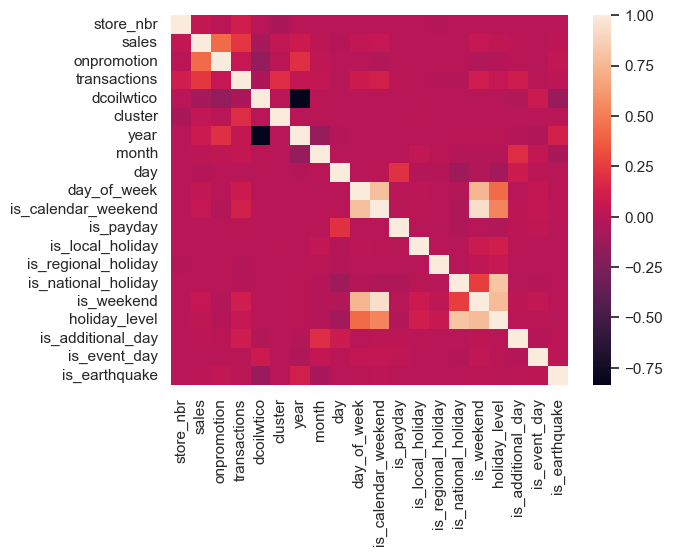

In [25]:
sns.heatmap(sales.corr(numeric_only=True));

In [ ]:
sales_enc = sales.copy()
sales_enc

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster,year,month,day,day_of_week,is_calendar_weekend,is_payday,is_local_holiday,is_regional_holiday,is_national_holiday,is_weekend,holiday_level,is_additional_day,is_event_day,is_earthquake
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
4,2013-01-01,1,BOOKS,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0


In [35]:
def one_hot_encode(df, column_name):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_array = encoder.fit_transform(df[[column_name]])

    columns_new = encoder.categories_[0]
    for i in range(len(columns_new)):
        category = columns_new[i].lower().replace("-", "_").replace(" ", "_")
        columns_new[i] = f"{column_name}_{category}"
    
    return pd.DataFrame(encoded_array, index=df.index, columns=columns_new)

In [ ]:
for column_name in ["family", "city", "state", "type"]:
    encoded_columns = one_hot_encode(sales_enc, column_name)
    sales_enc = pd.concat([sales_enc, encoded_columns], axis=1)
sales_enc

,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,city,state,type,cluster,year,month,day,day_of_week,is_calendar_weekend,is_payday,is_local_holiday,is_regional_holiday,is_national_holiday,is_weekend,holiday_level,is_additional_day,is_event_day,is_earthquake,family_automotive,family_baby_care,family_beauty,family_beverages,family_books,family_bread/bakery,family_celebration,family_cleaning,family_dairy,family_deli,family_eggs,family_frozen_foods,family_grocery_i,family_grocery_ii,family_hardware,...,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo,state_azuay,state_bolivar,state_chimborazo,state_cotopaxi,state_el_oro,state_esmeraldas,state_guayas,state_imbabura,state_loja,state_los_rios,state_manabi,state_pastaza,state_pichincha,state_santa_elena,state_santo_domingo_de_los_tsachilas,state_tungurahua,type_a,type_b,type_c,type_d,type_e
0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2013-01-01,1,BABY CARE,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2013-01-01,1,BEAUTY,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2013-01-01,1,BEVERAGES,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013-01-01,1,BOOKS,0.000,0,0,93.14,Quito,Pichincha,D,13,2013,1,1,1,0,0,0,0,1,1,4,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3000885,2017-08-15,9,PRODUCE,2419.729,148,2155,47.57,Quito,Pichincha,B,6,2017,8,15,1,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPL

In [43]:
sales_train = sales_enc[sales_enc.date <= '2017-07-15']
sales_test = sales_enc[sales_enc.date > '2017-07-15']

In [ ]:
# sales_train = sales_enc[sales_enc.date <= '2017-07-31']
# sales_test = sales_enc[sales_enc.date > '2017-07-31']

In [28]:
def add_lag_features_correct(train_df, test_df, lags=[1, 7, 14, 28]):
    """
    Правильное создание лагов без утечки данных
    """
    # 1. Объединяем train и test для правильного расчета лагов
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Сохраняем флаги для разделения обратно
    train_df['is_train'] = True
    test_df['is_train'] = False
    
    combined = pd.concat([train_df, test_df], ignore_index=True)
    combined = combined.sort_values(['store_nbr', 'family', 'date'])
    
    # 2. Создаем лаги на объединенных данных
    for lag in lags:
        combined[f'sales_lag_{lag}'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    
    # 3. Разделяем обратно
    train_result = combined[combined['is_train'] == True].drop('is_train', axis=1)
    test_result = combined[combined['is_train'] == False].drop('is_train', axis=1)
    
    return train_result, test_result

In [44]:
sales_train, sales_test = add_lag_features_correct(sales_train, sales_test)

In [33]:
def simple_fill_correct(train_df, test_df):
    """
    Простое заполнение пропусков без утечки
    """
    train_filled = train_df.copy()
    test_filled = test_df.copy()
    
    lag_columns = [col for col in train_df.columns if 'lag_' in col]
    
    # 1. Вычисляем медианы по группам на тренировочных данных
    store_family_medians = train_df.groupby(['store_nbr', 'family'])[lag_columns].median()
    global_medians = train_df[lag_columns].median()
    
    # 2. Заполняем тренировочные данные
    for col in lag_columns:
        # По store_nbr + family
        train_filled[col] = train_filled.apply(
            lambda row: store_family_medians.loc[(row['store_nbr'], row['family']), col] 
            if pd.isna(row[col]) else row[col], 
            axis=1
        )
        # Глобальная медиана
        train_filled[col] = train_filled[col].fillna(global_medians[col])
    
    # 3. Заполняем тестовые данные (только вычисленными статистиками!)
    for col in lag_columns:
        # По store_nbr + family (используем статистики с train)
        test_filled[col] = test_filled.apply(
            lambda row: store_family_medians.loc[(row['store_nbr'], row['family']), col] 
            if (pd.isna(row[col]) and 
                (row['store_nbr'], row['family']) in store_family_medians.index) 
            else row[col], 
            axis=1
        )
        # Глобальная медиана с train
        test_filled[col] = test_filled[col].fillna(global_medians[col])
    
    # 4. Заполняем все оставшиеся пропуски 0
    numeric_cols = train_filled.select_dtypes(include=[np.number]).columns
    train_filled[numeric_cols] = train_filled[numeric_cols].fillna(0)
    test_filled[numeric_cols] = test_filled[numeric_cols].fillna(0)
    
    return train_filled, test_filled

In [45]:
sales_train, sales_test = simple_fill_correct(sales_train, sales_test)

In [ ]:
def add_lag_features(df, lags=[1, 7, 14, 28, 365]):
    """Добавление лаговых фичей"""
    df = df.sort_values(['store_nbr', 'family', 'date'])
    
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    
    # Скользящие средние
    for window in [7, 14, 28]:
        df[f'sales_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
    
    return df


def smart_fill_strategy(df):
    """
    Разные стратегии для разных лагов
    """
    df_filled = df.copy()
    
    # 1. Лаг 1 день - заполняем вперед (минимальные пропуски)
    df_filled['sales_lag_1'] = df_filled.groupby(['store_nbr', 'family'])['sales_lag_1'].fillna(method='ffill')
    
    # 2. Лаги 7, 14, 28 дней - заполняем сезонными паттернами
    seasonal_lags = ['sales_lag_7', 'sales_lag_14', 'sales_lag_28']
    for col in seasonal_lags:
        # Заполняем значением с тем же днем недели/месяца
        df_filled[col] = df_filled.groupby(['store_nbr', 'family', 'day_of_week'])[col].transform(
            lambda x: x.fillna(x.median())
        )
    
    # 3. Лаг 365 дней - много пропусков, используем агрегированные значения
    df_filled['sales_lag_365'] = df_filled.groupby(['store_nbr', 'family', 'month', 'day_of_week'])[
        'sales_lag_365'
    ].transform(lambda x: x.fillna(x.median()))
    
    # 4. Заполняем оставшиеся пропуски глобальными статистиками
    lag_columns = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_lag_365']
    for col in lag_columns:
        # Если остались пропуски, заполняем медианой по магазину+семейству
        df_filled[col] = df_filled.groupby(['store_nbr', 'family'])[col].transform(
            lambda x: x.fillna(x.median() if not np.isnan(x.median()) else 0)
        )
    
    return df_filled

In [48]:
sales_train = sales_train.drop(columns=["date", "family", "city", "state", "type"])
sales_test = sales_test.drop(columns=["date", "family", "city", "state", "type"])

In [49]:
y_train = sales_train.sales
y_test = sales_test.sales

In [50]:
X_train = sales_train.drop(columns="sales")
X_test = sales_test.drop(columns="sales")

In [51]:
model = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=8,
    min_samples_leaf=20,
    l2_regularization=0.1,
    max_bins=255,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)
y_train_log = np.log1p(y_train)
model.fit(X_train, y_train_log)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,500
,max_leaf_nodes,31
,max_depth,8
,min_samples_leaf,20
,l2_regularization,0.1
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [52]:
y_pred_hgb = model.predict(X_test)
y_pred_hgb = np.expm1(y_pred_hgb)
y_pred_hgb = np.maximum(y_pred_hgb, 0)
root_mean_squared_log_error(y_test, y_pred_hgb)

0.39650149480396774